# AUTOENCODER

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Basic Autoencoder

In [2]:
# Basic Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim=784, encoding_dim=64):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, encoding_dim),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()  # Output between 0 and 1 for image reconstruction
        )
    
    def forward(self, x):
        # Encode
        encoded = self.encoder(x)
        # Decode
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        """Get encoded representation"""
        return self.encoder(x)
    
    def decode(self, x):
        """Decode from encoded representation"""
        return self.decoder(x)

# Convolutional Autoencoder

In [3]:
class ConvAutoencoder(nn.Module):
    """Convolutional Autoencoder for better image reconstruction"""
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # 14x14 -> 7x7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)  # 7x7 -> 1x1
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),  # 1x1 -> 7x7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),   # 14x14 -> 28x28
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Train Autoencoder

In [14]:
def train_autoencoder(model, train_loader, num_epochs=10, learning_rate=1e-3, device:str="cpu"):
    """Train the autoencoder"""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    model.train()
    losses = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            # Flatten data for fully connected autoencoder
            if isinstance(model, Autoencoder):
                data = data.view(data.size(0), -1)
            
            # Forward pass
            data = data.to(device)
            reconstructed = model(data)
            loss = criterion(reconstructed, data)
            data = data.to('cpu')
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    
    return losses

# Visualize Reconstruction

In [5]:
def visualize_reconstruction(model, test_loader, num_images=8):
    """Visualize original vs reconstructed images"""
    model.eval()
    with torch.no_grad():
        # Get a batch of test data
        data, _ = next(iter(test_loader))
        
        # Prepare data based on model type
        if isinstance(model, Autoencoder):
            data_input = data.view(data.size(0), -1)
            reconstructed = model(data_input)
            reconstructed = reconstructed.view(-1, 1, 28, 28)
        else:
            reconstructed = model(data)
        
        # Plot original and reconstructed images
        fig, axes = plt.subplots(2, num_images, figsize=(15, 4))
        
        for i in range(num_images):
            # Original images
            axes[0, i].imshow(data[i].squeeze(), cmap='gray')
            axes[0, i].set_title('Original')
            axes[0, i].axis('off')
            
            # Reconstructed images
            axes[1, i].imshow(reconstructed[i].squeeze(), cmap='gray')
            axes[1, i].set_title('Reconstructed')
            axes[1, i].axis('off')
        
        plt.tight_layout()
        plt.show()

# Run

Using mps device
Training Fully Connected Autoencoder...
Epoch [1/5], Loss: 0.0542
Epoch [2/5], Loss: 0.0253
Epoch [3/5], Loss: 0.0197
Epoch [4/5], Loss: 0.0165
Epoch [5/5], Loss: 0.0144

Training Convolutional Autoencoder...
Epoch [1/5], Loss: 0.0524
Epoch [2/5], Loss: 0.0104
Epoch [3/5], Loss: 0.0064
Epoch [4/5], Loss: 0.0049
Epoch [5/5], Loss: 0.0041

Visualizing reconstructions...


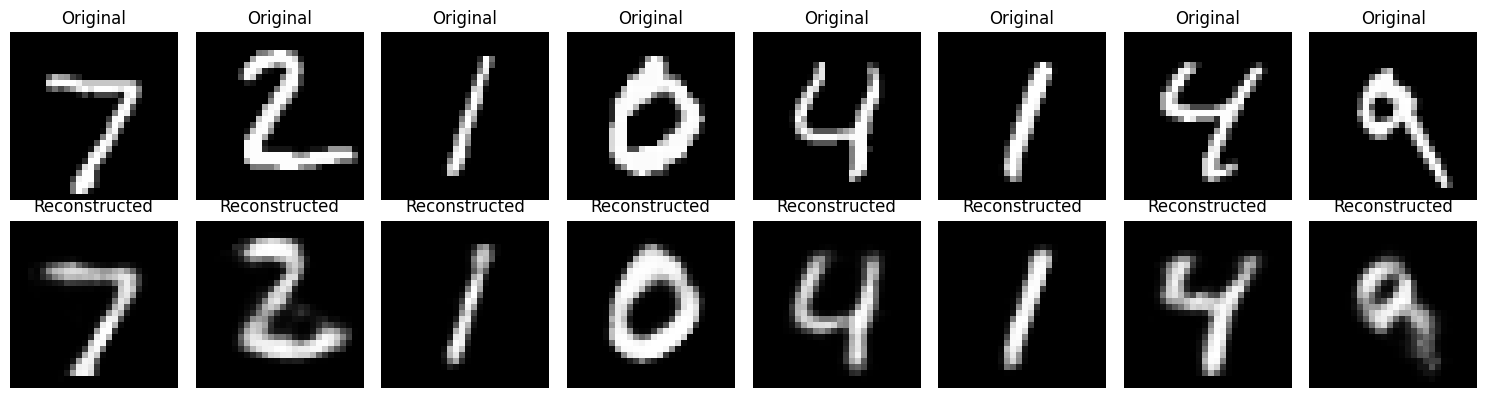

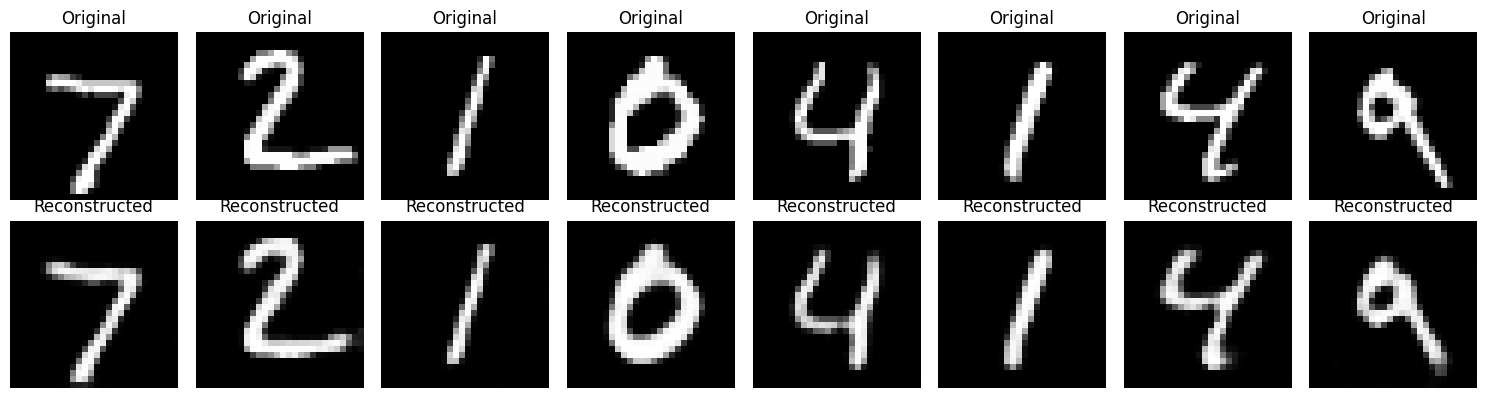

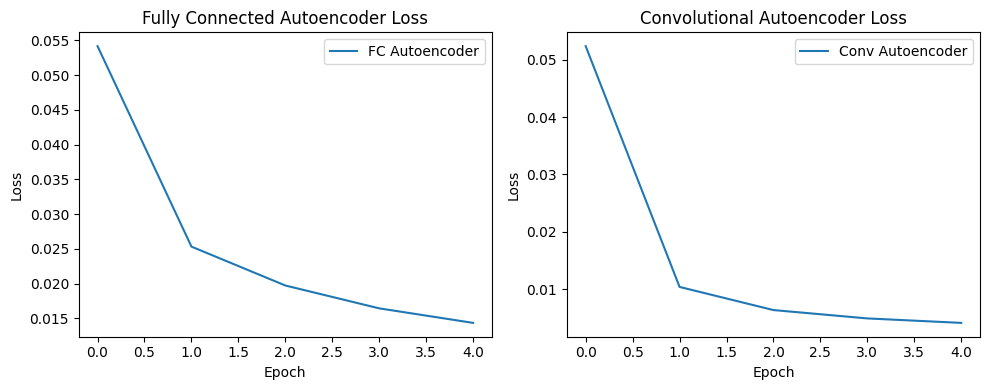


Testing encoder for dimensionality reduction...
Original data shape: torch.Size([128, 784])
Encoded data shape: torch.Size([128, 64])
Compression ratio: 12.2x


In [19]:
# Example usage
# Set device
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
#device = "cpu"
print(f"Using {device} device")

# Data loading
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print("Training Fully Connected Autoencoder...")
# Create and train fully connected autoencoder
fc_autoencoder = Autoencoder(input_dim=784, encoding_dim=64).to(device)
fc_losses = train_autoencoder(fc_autoencoder, train_loader, num_epochs=5, device=device)
fc_autoencoder = fc_autoencoder.to('cpu')

print("\nTraining Convolutional Autoencoder...")
# Create and train convolutional autoencoder
conv_autoencoder = ConvAutoencoder().to(device)
conv_losses = train_autoencoder(conv_autoencoder, train_loader, num_epochs=5, device=device)
conv_autoencoder = conv_autoencoder.to('cpu')

# Visualize results
print("\nVisualizing reconstructions...")
visualize_reconstruction(fc_autoencoder, test_loader)
visualize_reconstruction(conv_autoencoder, test_loader)

# Plot training losses
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(fc_losses, label='FC Autoencoder')
plt.title('Fully Connected Autoencoder Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(conv_losses, label='Conv Autoencoder')
plt.title('Convolutional Autoencoder Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Example of using the encoder for dimensionality reduction
print("\nTesting encoder for dimensionality reduction...")
fc_autoencoder.eval()
with torch.no_grad():
    sample_data, _ = next(iter(test_loader))
    sample_data_flat = sample_data.view(sample_data.size(0), -1)
    
    # Original dimension: 784 (28x28)
    print(f"Original data shape: {sample_data_flat.shape}")
    
    # Encoded dimension: 64
    encoded_data = fc_autoencoder.encode(sample_data_flat)
    print(f"Encoded data shape: {encoded_data.shape}")
    
    # Compression ratio
    compression_ratio = 784 / 64
    print(f"Compression ratio: {compression_ratio:.1f}x")